In [1]:
import sys
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import cv2 

/home/neru/M5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
#load dataset
annotations_path = "./annotations/instances_val2017.json"
database_path = "./val2017/"
coco_annotation=COCO(annotations_path)
 
 

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


ANNOTATION [{'segmentation': [[216.81, 9.58, 225.44, 13.9, 237.3, 21.45, 243.78, 21.45, 250.25, 49.49, 267.51, 59.2, 284.76, 87.24, 292.31, 91.56, 285.84, 120.68, 285.84, 133.63, 273.98, 139.02, 276.13, 145.49, 258.88, 172.46, 263.19, 179.27, 261.03, 205.9, 266.43, 218.84, 276.13, 239.33, 298.79, 245.81, 310.65, 240.41, 307.42, 225.31, 302.02, 203.74, 310.65, 191.87, 318.2, 168.14, 333.3, 153.04, 325.75, 189.72, 319.28, 231.78, 304.69, 286.9, 382.92, 298.66, 379.69, 286.8, 373.21, 286.8, 358.11, 285.72, 351.64, 278.17, 370.95, 215.59, 387.24, 182.17, 393.94, 159.62, 395.87, 137.94, 400.18, 127.16, 394.79, 53.81, 395.87, 39.78, 382.92, 13.9, 381.84, 2.03, 381.84, 2.03, 211.42, 2.03, 220.04, 9.58], [413.12, 2.03, 407.04, 13.55, 406.68, 35.85, 412.42, 41.23, 404.17, 41.94, 408.46, 52.73, 414.19, 51.27, 430.74, 48.78, 433.62, 36.55, 432.54, 19.29, 429.3, 13.9, 425.0, 0.61, 414.91, 0.0]], 'area': 32042.990900000008, 'iscrowd': 0, 'image_id': 112110, 'bbox': [211.42, 0.0, 222.2, 298.66], 'ca

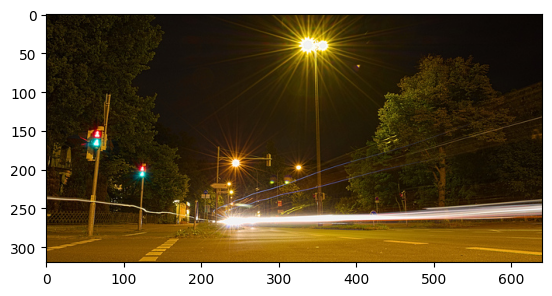

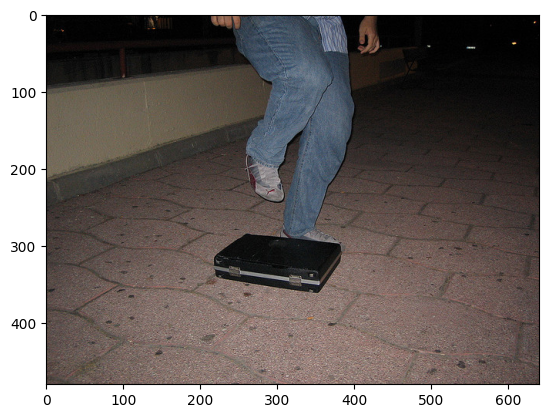

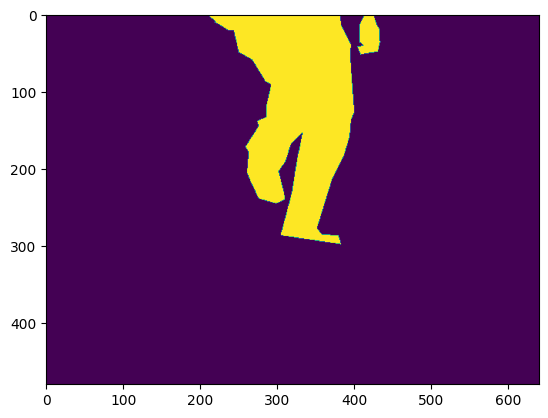

In [34]:

# Get list of category_ids, here [2] for bicycle


img1_filename = random.choice(os.listdir(database_path)) #change dir name to whatever
img2_filename = random.choice(os.listdir(database_path)) #change dir name to whatever
img1 = cv2.imread(database_path+img1_filename)
img2 = cv2.imread(database_path+img2_filename)
img1_id = int(img2_filename.split('.')[0])
img2_id = int(img2_filename.split('.')[0])

img1_info = coco_annotation.loadImgs([img1_id])[0]
img1_height = img1_info["height"]
img1_width = img1_info["width"]

random_annotation_ids = coco_annotation.getAnnIds(imgIds=img2_id)
random_annotation_id = random_annotation_ids[random.randint(0, len(random_annotation_ids)-1)]   #pick 1
random_annotation_img2  = coco_annotation.loadAnns(random_annotation_id)
random_mask_img2 = coco_annotation.annToMask(random_annotation_img2[0])

plt.figure()
plt.imshow(img1[:,:,::-1])
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.figure()
plt.imshow(random_mask_img2)

print("ANNOTATION" ,random_annotation_img2)
print(len(random_annotation_ids))

print("Image 1 (target): ",img1_filename)
print("Image 2 (source): ",img2_filename)

print("IMG 1 info ", img1_height)
im = img1.copy()


In [18]:
def load_random_image(annotations, database_path):

    random_img_filename = random.choice(os.listdir(database_path)) #change dir and pick random image
    random_img = cv2.imread(database_path+random_img_filename)  #read image
    random_img_id = int(random_img_filename.split('.')[0])  #get id

    random_annotation_ids = annotations.getAnnIds(imgIds=random_img_id)   #get annotations (list of all gt detections in image)
    random_annotation_id = random_annotation_ids[random.randint(0, len(random_annotation_ids)-1)]   #pick 1
    random_annotation_img  = annotations.loadAnns(random_annotation_id)
    random_mask= annotations.annToMask(random_annotation_img[0])
    
    print("Random image filename: ",random_img_filename)
    print("Random image annotations" ,random_annotation_img)
    return random_img, random_mask

def load_image_and_annotations(img_filename, database_path):
    img = cv2.imread(database_path+img_filename)
    img_id = int(img1_filename.split('.')[0])
    info = coco_annotation.loadImgs([img_id])
    return img, info




Random image filename:  000000292060.jpg
Random image annotations [{'segmentation': [[311.17, 272.25, 312.02, 276.91, 315.83, 276.49, 319.22, 279.24, 322.82, 286.45, 323.03, 290.47, 305.45, 298.95, 300.16, 294.28, 298.04, 286.66, 298.46, 283.48, 301.64, 281.79, 302.27, 275.64, 304.82, 273.1, 308.84, 271.83]], 'area': 434.58544999999964, 'iscrowd': 0, 'image_id': 292060, 'bbox': [298.04, 271.83, 24.99, 27.12], 'category_id': 47, 'id': 673722}]
Target image:  000000477955.jpg


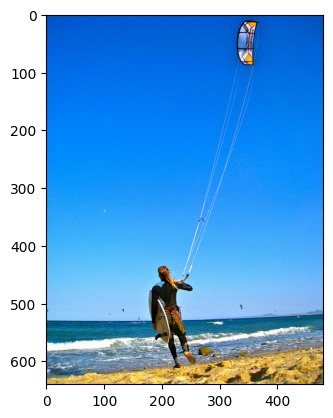

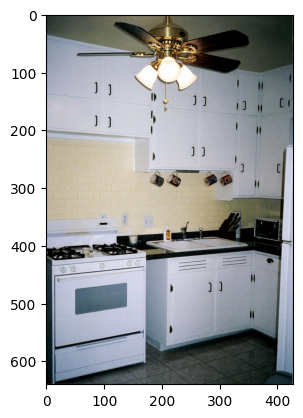

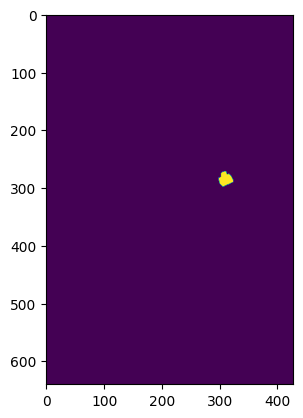

In [19]:
#load main image
img1_filename = random.choice(os.listdir(database_path)) #pick randomly or select a filename
img1, info_img1 = load_image_and_annotations(img1_filename, database_path)
img1_h, img1_w, img1_chann = img1.shape

#load random image
img2, random_mask_img2 = load_random_image(coco_annotation, database_path)

plt.figure()
plt.imshow(img1[:,:,::-1])
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.figure()
plt.imshow(random_mask_img2)

print("Target image: ",img1_filename)

im = img1.copy()


In [41]:
def pad_image(img, new_image_height, new_image_width):
    
    color = (0,0,0)
    if len(img.shape)==3:
        old_image_height, old_image_width, channels = img.shape
        
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    if len(img.shape)==2:
        old_image_height, old_image_width = img.shape
        result = np.full((new_image_height,new_image_width), 0, dtype=np.uint8)


    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
        x_center:x_center+old_image_width] = img
    return result
def transplant_images(image_1, image_2,image_2_mask):

    image_1_copy = image_1.copy() 

    #--- Copy pixel values of logo image to room image wherever the mask is white ---
    image_1_copy[np.where(image_2_mask == 1)] = image_2[np.where(image_2_mask == 1)]

    return image_1_copy

def apply_transformation(img, tx,ty, angle):
    
    # Rotate the image using cv2.warpAffine()
    M = cv2.getRotationMatrix2D((ty, tx), angle, 1)
    warped_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return warped_img



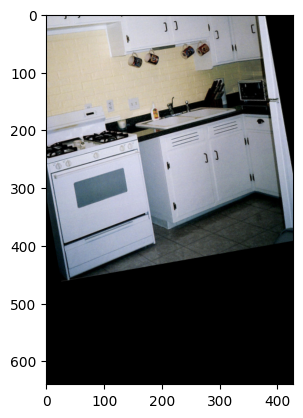

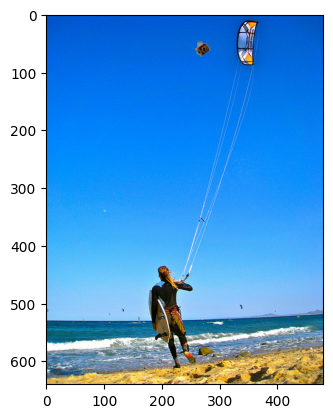

In [45]:
tx =400
ty = -1000
rotation_angle_deg = 10
warped_image = apply_transformation(img2,tx, ty,rotation_angle_deg)
warped_mask =  apply_transformation(random_mask_img2,tx, ty,rotation_angle_deg)
#padded_image =  pad_image(warped_image,img1_h, img1_w)
#padded_mask_2 =  pad_image(warped_mask,img1_h, img1_w)

plt.figure()
plt.imshow(warped_image[:,:,::-1])
new_image =  transplant_images(img1, warped_image,warped_mask)

plt.figure()
plt.imshow(new_image[:,:,::-1])


In [22]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

In [38]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs = predictor(img1)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

outputs_transplant = predictor(new_image)
print(outputs_transplant["instances"].pred_classes)
print(outputs_transplant["instances"].pred_boxes)

tensor([9, 9, 9, 9, 9, 9, 9])
Boxes(tensor([[283.4954, 180.8841, 290.9732, 197.5918],
        [ 58.4012, 149.6854,  72.2490, 175.5474],
        [119.6278, 194.6047, 128.9010, 212.4717],
        [456.4844, 229.3899, 460.7416, 236.9865],
        [344.4149, 231.5106, 348.6517, 239.7381],
        [355.5016, 230.9570, 360.4710, 239.9777],
        [287.9432, 213.9564, 295.2599, 221.2416]]))
tensor([0, 9, 9, 0, 9])
Boxes(tensor([[217.7537,   0.0000, 416.0927, 302.8699],
        [ 58.4012, 149.6854,  72.2490, 175.5474],
        [119.6278, 194.6047, 128.9010, 212.4717],
        [404.6208,   0.6612, 433.7229,  52.2125],
        [456.4835, 229.4051, 460.7326, 236.9916]]))


In [24]:
def predict(predictor, img):
    outputs = predictor(img)
    output_predictions = outputs["instances"].pred_classes
    print(output_predictions)
    print(outputs["instances"].pred_boxes)

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image= out.get_image()
    return output_image, output_predictions

tensor([ 0, 33, 33, 37, 33])
Boxes(tensor([[178.3994, 433.3324, 258.8235, 611.6727],
        [329.4122,  12.3402, 367.3362,  88.5140],
        [334.0989, 502.6201, 339.3804, 510.6012],
        [187.4230, 488.2293, 217.0672, 569.2127],
        [131.0210, 509.7454, 134.7688, 515.5660]]))
tensor([ 0, 33, 33, 33, 37, 33])
Boxes(tensor([[178.3994, 433.3325, 258.8235, 611.6727],
        [324.9595, 272.6101, 348.9587, 298.1988],
        [329.4122,  12.3402, 367.3362,  88.5140],
        [334.0989, 502.6201, 339.3804, 510.6012],
        [187.4230, 488.2293, 217.0672, 569.2127],
        [131.0210, 509.7454, 134.7688, 515.5660]]))


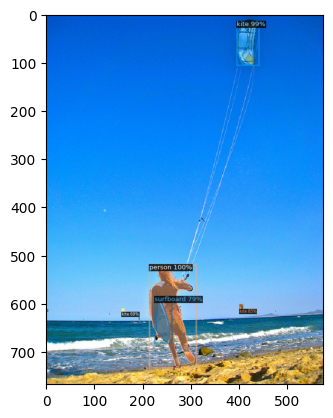

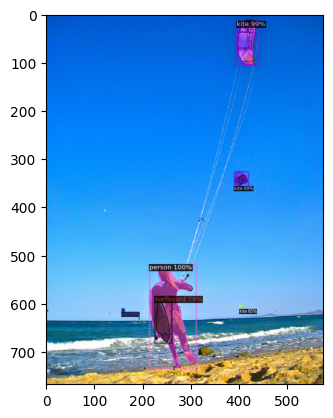

In [26]:

output_image_1, _ = predict(predictor, img1)
plt.figure()
plt.imshow(output_image_1)
output_new_image, _ = predict(predictor,new_image)
plt.figure()
plt.imshow(output_new_image)
